In [3]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
reload(figure_utils)

<module 'figure_utils' from 'c:\\github\\Segmentation\\figure_utils.py'>

# Dice coefficient

In [ ]:
# Step 3. Segmentation vs segmentation. This will create a csv file for each number of clusters and each permutation test
# This will generate a csv file for each number of clusters. If rnd each repetition of the permutation test as well
# Last used 8/Jun/2025 to get Johnson_gyri and Johnson_lobe
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
reload(figure_utils)

# running get clusters
comp_names = ['beagle','others','all','healthy', 'Johnson', 'Johnson_gyri', 'Johnson_lobe', 'Knee']
comp_N = 7 # 7 for Knee, 0 for epi1, 1 for epi2, 2 for epi, 3 for healthy
rnd = False # True for individual permutations per segment, False for original data
username = 'raulh87'
dataset = 'CAPS_K9'
local_data=True

if rnd == False:
    n_reps = 0
else:
    n_reps = 1000

project_dict_test = figure_utils.get_project_dict(comp_names[comp_N])[0]
project_dict_base = figure_utils.get_project_dict('K9')[0]

experiment = 'CAPS'
if rnd:
    results_path = r"C:\github\spatially_constrained_spectral_clustering\results_rnd"
else:
    results_path = r"C:\github\spatially_constrained_spectral_clustering\results"


for number_of_clusters in [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]:
    # get a list of files matching the number of cluster and any permutation
    clusters_test,clusters_ID_test = figure_utils.get_clusters(project_dict_test, number_of_clusters)
    if rnd == False:
        perms_numbers = [0]
    else:
        perms_numbers = figure_utils.which_cluster_files(project_dict_base, number_of_clusters)
    # print number of permutations available
    print('Number of permutations available: ' + str(len(perms_numbers)))
    for rnd_N in perms_numbers:
        if rnd == False and rnd_N != 0: # only run once for original data
            data_table_path = os.path.join(results_path, 'data_table_' + str(number_of_clusters) + '_' + comp_names[comp_N] + '.csv')
            break
        else:
            data_table_path = os.path.join(results_path, 'data_table_' + str(number_of_clusters) + '_' + comp_names[comp_N] + '_' + str(rnd_N).zfill(4) + '.csv')
            # clear the output
            os.system('cls' if os.name == 'nt' else 'clear')
            print('Running for ' + str(rnd_N) + 'th repetition out of ' + str(len(perms_numbers)))
        # check if data_table_path exists, if it does, skip this iteration
        if os.path.exists(data_table_path):
            print('Data table already exists: ' + data_table_path, 'Skipping...')
            continue

        # check if data_table_path folder exists, if not create it
        if not os.path.exists(os.path.dirname(data_table_path)):
            os.makedirs(os.path.dirname(data_table_path))

        
        clusters_base,clusters_ID_base = figure_utils.get_clusters(project_dict_base, number_of_clusters, rnd, rnd_N)

        # initialize data_table
        data_table = pd.DataFrame(columns=['ID_epi', 'N_voxels_epi', 'ID_K9', 'N_voxels_K9', 'Union', 'Dice_coeff', 'Overlap', 'Index', 'Expected_index', 'Max_index', 'ARI'])

        # calculate total number of voxels
        n_voxels = sum(len(v) for v in clusters_test.values())
        n_voxels2 = sum(len(v) for v in clusters_base.values())
        # make sure the number of voxels is the same, if not, raise an error
        if n_voxels != n_voxels2:
            print('n_voxels_epi: ' + str(n_voxels))
            print('n_voxels_K9: ' + str(n_voxels2))
            raise ValueError('The number of voxels in the two cluster maps is different')

        for n_epi in clusters_ID_test:
            for n_K9 in clusters_ID_base:
                dice_coeff = 2*len(set(clusters_test[n_epi]) & set(clusters_base[n_K9]))/(len(clusters_test[n_epi]) + len(clusters_base[n_K9]))
                # For Adjusted Rand Index
                overlap = len(set(clusters_test[n_epi]) & set(clusters_base[n_K9]))
                index = comb(overlap, 2)
                sum_a = len(clusters_test[n_epi])
                sum_b = len(clusters_base[n_K9])
                expected = comb(sum_a, 2) * comb(sum_b, 2) / comb(n_voxels, 2)
                max_index = 0.5 * (comb(sum_a, 2) + comb(sum_b, 2))
                ari = (index - expected) / (max_index - expected) if max_index != expected else 0


                new_row = {
                    'ID_epi': n_epi,
                    'N_voxels_epi': len(clusters_test[n_epi]),
                    'ID_K9': n_K9,
                    'N_voxels_K9': len(clusters_base[n_K9]),
                    'Union': len(set(clusters_test[n_epi]) & set(clusters_base[n_K9])),
                    'Dice_coeff': dice_coeff,
                    'Overlap': overlap,
                    'Index': index,
                    'Expected_index': expected,
                    'Max_index': max_index,
                    'ARI': ari,
                }
                # add the new row to the data_table
                data_table = pd.concat([data_table, pd.DataFrame([new_row])], ignore_index=True)
        # Clean up table
        # filter out the rows with Overlap = 0
        data_table = data_table[data_table['Overlap'] != 0]
        # sort the data_table by Overlap
        data_table = data_table.sort_values(by='Overlap', ascending=False)
        # add number of repetitions to the table
        data_table['rnd_N'] = rnd_N

        # save the data_table
        data_table.to_csv(data_table_path, index=False)
        print('Data table saved to: ' + data_table_path)


SyntaxError: invalid syntax (4060063415.py, line 72)

# Combine to a single table

Merges all the reproducibility stats calculated in the previous step

In [ ]:
# Step 4. Use Kuhn-Munkres for best assigment and join in single table
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
reload(figure_utils)

comp_dicts = {'healthy': figure_utils.get_project_dict('healthy')[0],
              'Johnson': figure_utils.get_project_dict('Johnson')[0],
              'Johnson_gyri': figure_utils.get_project_dict('Johnson_gyri')[0],
              'Johnson_lobe': figure_utils.get_project_dict('Johnson_lobe')[0],
              'Knee': figure_utils.get_project_dict('Knee')[0],
              }

comp_dicts_keys = ['healthy', 'Johnson', 'Johnson_gyri', 'Johnson_lobe', 'Knee']

results_path = r"C:\github\spatially_constrained_spectral_clustering\results"

number_of_clusters_list = [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]


for comp_type in comp_dicts_keys:
    # create an empty dataframe to store the results
    final_table = pd.DataFrame()
    print('Comp type: ' + comp_type)
    # list of number of clusters
    

    for number_of_clusters in number_of_clusters_list:
        # get the data_table_path
        data_table_path = os.path.join(results_path, 'data_table_' + str(number_of_clusters) + '_' + comp_type + '_0000.csv')
        # load the data_table
        data_table = pd.read_csv(data_table_path)
        # fill_missing_pairs
        data_table = figure_utils.fill_missing_pairs(data_table)


        # filter using Kuhn-Munkres
        data_table_sel = figure_utils.best_assignment_Kuhn(data_table)

        # Add number of clusters to the data_table
        data_table_sel['N_clusters'] = number_of_clusters

        final_table = pd.concat([final_table, data_table_sel], ignore_index=True)
    # final table file name
    final_table_path = os.path.join(results_path, 'table_' + comp_type + '.csv')
    # save the final_table
    final_table.to_csv(final_table_path, index=False)
    print('Table saved to: ' + final_table_path)
print("done")


Comp type: Knee
Table saved to: G:\My Drive\Results\\CAPS\cluster_stats\table_Knee.csv
done


Table with average Dice coeff per number of clusters saved to: G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_Johnson.csv
Table with average Dice coeff per number of clusters saved to: G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_Johnson_gyri.csv
Table with average Dice coeff per number of clusters saved to: G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_Johnson_lobe.csv
Figure saved to: C:\github\Segmentation\Figures\Figure_D\Dice_coeff_Johnson_three.png


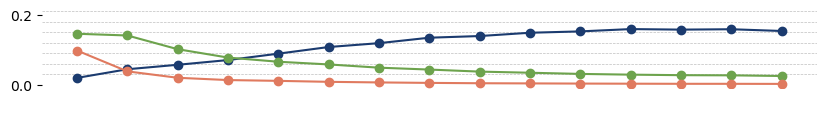

In [ ]:
# Figure D - Johnson Comparisons
# Generate scatter plot, x number of clusters, y Dice_coeff.
# Clear all the variables
%reset -f
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
from matplotlib import pyplot as plt
reload(figure_utils)
import matplotlib.ticker as mticker   # ← new import

figure_letter = 'D'
grid_spacing = 0.03
username = 'raulh87'
vars_to_use = ['Dice_coeff']

comp_names = ['Johnson','Johnson_gyri','Johnson_lobe']
# x_shift = [0, 1, 2]  # Shift for each comparison to avoid overlap in the x-axis

save_file = True
color_comb = 'white' # tales 'white' or 'black'

if color_comb == 'white':
    opposite_color = 'black'
elif color_comb == 'black':
    opposite_color = 'white'
else:
    raise ValueError('color_comb must be white or black')

dataset = 'CAPS_K9'
experiment = 'CAPS'
figure_dims = (10, 1)
project_dict = figure_utils.get_project_dict('K9')[0]
figures_folder = figure_utils.get_path('Figures', project_dict, figure_letter=figure_letter)
# create figure
fig, ax = plt.subplots(figsize=figure_dims)
# initialize min_ylist and max_y_list
min_y_list, max_y_list = [], []
for comp in comp_names:
    # get project_dict for the comparison
    project_dict_comp = figure_utils.get_project_dict(comp)[0]
    # Make a plot for each stat
    # res_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_all.csv"
    res_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_" + comp + ".csv"
    # Load the res_df
    res_df = pd.read_csv(res_path)
    cluster_possible_list = res_df['N_clusters'].unique()
    res_by_n_clusters = pd.DataFrame()
    for N_clusters in cluster_possible_list:
        # Create a figure according to figure_dims
        res_df_sel = res_df[res_df['N_clusters'] == N_clusters]
        new_row = {
            'number_of_clusters': N_clusters,
            'Dice_coeff': np.mean(res_df_sel['Dice_coeff'].values),
        }
        # add new_row to res_by_n_clusters
        res_by_n_clusters = pd.concat([res_by_n_clusters, pd.DataFrame([new_row])], ignore_index=True)
    # setup path to save the table
    res_table_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_" + comp + ".csv"
    # save the res_by_n_clusters
    res_by_n_clusters.to_csv(res_table_path, index=False)
    print('Table with average Dice coeff per number of clusters saved to: ' + res_table_path)
    # create figure
    # fig, ax = plt.subplots(figsize=figure_dims)
    # get the y values and x values
    y_values = res_by_n_clusters['Dice_coeff'].values
    x_values = res_by_n_clusters['number_of_clusters'].values
    # shift x values to avoid overlap
    # x_values = x_values + x_shift[comp_names.index(comp)]

    # plot the data
    ax.plot(x_values, y_values, 'o-', label='Data', color=project_dict_comp['color'])
    
    # add min_y and max_y to lists
    min_y_list.append(np.min(y_values))
    max_y_list.append(np.max(y_values))


    # min_y_list = min(y_values)
    # max_y_list = max(y_values)

min_y = min(min_y_list)
max_y = max(max_y_list)
# define percentage to add to the y-axis
perc = 0.1

# add 10% of the y-axis
# if min_y < 0:
#     min_y = min_y + min_y*perc
# else:
#     min_y = min_y - min_y*perc
if max_y < 0:
    max_y = max_y - max_y*perc
else:
    max_y = max_y + max_y*perc


# round min_y to the nearest 0.1
min_y = 0#round(min_y - 0.01, 2)

# round max_y to the nearest 0.1
max_y = round(max_y + 0.01, 2)
max_y = 0.20

ax.set_ylim([min_y, max_y])

# ─────────────── y-axis ticks & grid ───────────────
# major ticks: just min and max
ax.yaxis.set_major_locator(mticker.FixedLocator([min_y, max_y]))
# minor ticks: every grid_spacing
ax.yaxis.set_minor_locator(mticker.MultipleLocator(grid_spacing))
# draw grid only at minor ticks
ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
# optionally turn off any major grid
ax.grid(which='major', color='none')

# ensure only major tick labels appear
ax.tick_params(axis='y', which='minor', length=0)

# Set the background color to none
ax.set_facecolor('none')

for spine in ['top','left','right','bottom']:
    ax.spines[spine].set_visible(False)
# hide x-axis ticks and labels
ax.tick_params(axis='x', colors='none')
# color the y-axis labels
ax.tick_params(axis='y', colors=opposite_color)

margin = 0.01
ax.set_ylim(min_y - margin, max_y + margin)

# Determine path
figure_path = os.path.join(figures_folder, 'Dice_coeff_Johnson_three' + '.png')
if save_file:
    # check if folder exists, if not create it
    if not os.path.exists(figures_folder):
        os.makedirs(figures_folder)
        print('Folder created: ' + figures_folder)

    # Save the figure with transparency
    fig.savefig(figure_path, transparent=True)
    print('Figure saved to: ' + figure_path)
else:
    print(figure_path + ' not saved')


Table with average Dice coeff per number of clusters saved to: G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_healthy.csv


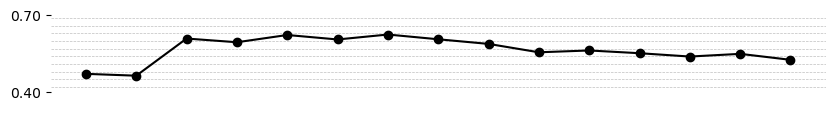

Figure saved to: C:\github\Segmentation\Figures\Figure_C\healthy_Dice_coeff.png
Table with average Dice coeff per number of clusters saved to: G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_Knee.csv


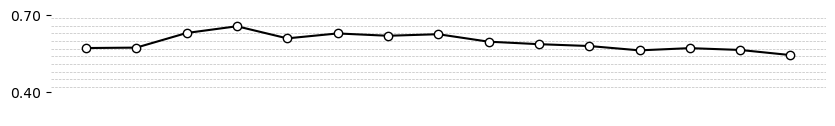

Figure saved to: C:\github\Segmentation\Figures\Figure_C\Knee_Dice_coeff.png


In [ ]:
# Figure C - Reproducibility
# Generate scatter plot, x number of clusters, y Dice_coeff. Distribution of Dice coeff added below
# This version creates a single plot for each comparison type (e.g., Johnson_gyri, Johnson_lobe)
# 8/Sep/2025

# Clear all the variables
%reset -f
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
from matplotlib import pyplot as plt
reload(figure_utils)
import matplotlib.ticker as mticker   # ← new import

figure_letter = 'C'
grid_spacing = 0.03
username = 'raulh87'
vars_to_use = ['Dice_coeff', 'ARI']
vars_to_use = ['Dice_coeff']
stat_to_plot = 'z' # m: mean or z: for z-score
comp_names = ['all','healthy','Johnson','Johnson_gyri','Johnson_lobe']
comp_names = ['all','healthy','Johnson','Johnson_gyri','Johnson_lobe', 'Knee']
comp_names = ['healthy','Knee']
# generate dict for each comp_names with min_y, max_y. All have NaN
y_limits_dict = {comp: {'min_y': np.nan, 'max_y': np.nan} for comp in comp_names}
## set healthy props. to 0.40 and 0.70
y_limits_dict['healthy']['min_y'] = 0.40
y_limits_dict['healthy']['max_y'] = 0.70

## set Knee props. to 0.40 and 0.70
y_limits_dict['Knee']['min_y'] = 0.40
y_limits_dict['Knee']['max_y'] = 0.70






save_file = True
color_comb = 'white' # tales 'white' or 'black'

if color_comb == 'white':
    opposite_color = 'black'
elif color_comb == 'black':
    opposite_color = 'white'
else:
    raise ValueError('color_comb must be white or black')

dataset = 'CAPS_K9'
experiment = 'CAPS'
figure_dims = (10, 1)
project_dict = figure_utils.get_project_dict('K9')[0]
figures_folder = figure_utils.get_path('Figures', project_dict, figure_letter=figure_letter)

for comp in comp_names:
    # Make a plot for each stat
    # res_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_all.csv"
    res_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_" + comp + ".csv"
    # Load the res_df
    res_df = pd.read_csv(res_path)
    cluster_possible_list = res_df['N_clusters'].unique()
    res_by_n_clusters = pd.DataFrame()
    for N_clusters in cluster_possible_list:
        # Create a figure according to figure_dims
        res_df_sel = res_df[res_df['N_clusters'] == N_clusters]
        new_row = {
            'number_of_clusters': N_clusters,
            'Dice_coeff': np.mean(res_df_sel['Dice_coeff'].values),
        }
        # add new_row to res_by_n_clusters
        res_by_n_clusters = pd.concat([res_by_n_clusters, pd.DataFrame([new_row])], ignore_index=True)
    
    # setup path to save the table
    res_table_path = r"G:\My Drive\Results\CAPS\cluster_stats\table_per_N_clusters_" + comp + ".csv"
    # save the res_by_n_clusters
    res_by_n_clusters.to_csv(res_table_path, index=False)
    print('Table with average Dice coeff per number of clusters saved to: ' + res_table_path)

    # create figure
    fig, ax = plt.subplots(figsize=figure_dims)
    # get the y values and x values
    y_values = res_by_n_clusters['Dice_coeff'].values
    x_values = res_by_n_clusters['number_of_clusters'].values
    # plot the data
    ax.plot(x_values, y_values, 'o-', label='Data', color=opposite_color)
    
    # get min_y and max_y
    min_y = min(y_values)
    max_y = max(y_values)
    # define percentage to add to the y-axis
    perc = 0.1
    
    # add 10% of the y-axis
    if min_y < 0:
        min_y = min_y + min_y*perc
    else:
        min_y = min_y - min_y*perc
    if max_y < 0:
        max_y = max_y - max_y*perc
    else:
        max_y = max_y + max_y*perc
   

    # round min_y to the nearest 0.1
    min_y = round(min_y - 0.01, 2)
    
    # round max_y to the nearest 0.1
    max_y = round(max_y + 0.01, 2)

    # if min_y <= 0.1 make it zero
    if min_y <= 0.1:
        min_y = 0

    # overwrite if min_x is not nan for this comp
    if not np.isnan(y_limits_dict[comp]['min_y']):
        min_y = y_limits_dict[comp]['min_y']
    if not np.isnan(y_limits_dict[comp]['max_y']):
        max_y = y_limits_dict[comp]['max_y']

    ax.set_ylim([min_y, max_y])

    # ─────────────── y-axis ticks & grid ───────────────
    # major ticks: just min and max, pad two decimals
    ax.yaxis.set_major_locator(mticker.FixedLocator([min_y, max_y]))
    # minor ticks: every grid_spacing
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(grid_spacing))
    # # Format y-axis tick labels to always show two decimals
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    # ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter('%.2f'))
    
    # draw grid only at minor ticks
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    # optionally turn off any major grid
    ax.grid(which='major', color='none')
    
    # ensure only major tick labels appear
    ax.tick_params(axis='y', which='minor', length=0)

    # Set the background color to none
    ax.set_facecolor('none')

    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_visible(False)
    # hide x-axis ticks and labels
    ax.tick_params(axis='x', colors='none')
    # color the y-axis labels
    ax.tick_params(axis='y', colors=opposite_color)
    
    
    # Show the plot
    plt.show()

    # Determine path
    figure_path = os.path.join(figures_folder, comp + '_' + 'Dice_coeff' + '.png')
    if save_file:
        # check if folder exist
        if not os.path.exists(figures_folder):
            os.makedirs(figures_folder)
        # Save the figure with transparency
        fig.savefig(figure_path, transparent=True)
        print('Figure saved to: ' + figure_path)
    else:
        print(figure_path + ' not saved')


In [ ]:
# Figure C. Brain slices with segments colored by cluster number
# Each slice will have all clusters matching each number of clusters and show Dice_coeff per segment

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import os
import copy  # Added import
from importlib import reload
import figure_utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import ListedColormap


reload(figure_utils)

project_dict = figure_utils.get_project_dict('K9')[0]
figure_letter = 'A'

# Add options
zero_transparent = True  # If True, zeros in segment_map and slice_base are set to np.nan
nan_transparent = True   # If True, NaNs in segment_map are plotted as transparent; if False, print "decision pending"
alpha = 1.0               # Transparency of overlay
stat_to_plot = 'z' # m: mean or z: for z-score
variable_name = 'Homogeneity'  # 'Homogeneity' 
write_nii = True # If True, write the nii file
write_file=True
clear_background=True
alphabetic_slides = True

# plot details
font_family='Arial'
font_size=20
font_color = 'white'
cmap_name = 'hot' # takes hot bwr 
simetrical_cmap = False # If True, the cmap will be simetrical
local_data = True

specie = 'D'


comp_names = ['Knee','healthy', 'Johnson', 'Johnson_gyri', 'Johnson_lobe']

results_output_folder = r"C:\github\spatially_constrained_spectral_clustering\Figures"

var = 'Dice_coeff'

min_val_assigned = []
max_val_assigned = []

project_dict = figure_utils.get_project_dict('K9')[0]
figure_letter = 'A'
# figures_output_folder = r"G:\My Drive\Results\CAPS\Figures\Figure_A"

figures_output_folder = figure_utils.get_path('Figures', project_dict, figure_letter)
nii_folder = os.path.join(results_output_folder, "Figure_" + figure_letter)

img_type = "b_GreyMatter2mm"
base_img = "Czeibert_brain2mm"
atlas_type = project_dict['Atlas_type']


slice_params = {
    'z': [32],
    'cmap': cmap_name,
}
cmap_type = slice_params['cmap']

cluster_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

# iterate over each possible comparison
for comp_name in comp_names:
    res_df_path = r"C:\github\spatially_constrained_spectral_clustering\results\table_" + comp_name + ".csv"
    # load res_df
    res_df = pd.read_csv(res_df_path)
    # get the unique values of the variable
    unique_vals = res_df[var].unique()
    # get the min and max values
    min_val = np.min(unique_vals)
    max_val = np.max(unique_vals)
    
    # if min_val_assigned is not empty
    # check if min_val_assigned is not empty
    if min_val_assigned:
    # if len(min_val_assigned) > 0: # check if min_val_assigned is not empty
        # assign min_val
        print('Min value assigned')
        min_val = min_val_assigned
    # check if max_val_assigned is not empty
    if max_val_assigned:
    # if len(max_val_assigned) > 0: # check if max_val_assigned is not empty
        # assign max_val
        max_val = max_val_assigned
    # print the min and max values
    print('Min value: ' + str(min_val))
    print('Max value: ' + str(max_val))
    
    # go through the res_df and assign create slice (or single slice) for each number of clusters
    for number_of_clusters in cluster_list:
    # for number_of_clusters in cluster_list:
        segment_map_path = os.path.join(
                figure_utils.get_datafolder(username, local_data),
                project_dict['Dataset'],
                'hierarchical_clustering',
                f"{specie}-group-tcorr-{img_type}_{number_of_clusters}.nii.gz"
            )
        # filter by number of clusters
        res_df_sel = res_df[res_df['N_clusters'] == number_of_clusters]

        try:
            res_df_sel = res_df_sel[~res_df_sel['ID_K9'].str.startswith('__DUMMY')]
        #catch
        except:
            print(f"'ID_K9' dummy not found in res_df_sel for {comp_name} with {number_of_clusters} clusters.")
            

        cluster_ID_list = res_df_sel['ID_K9'].unique()
        
        # Load the data map
        segment_map = nib.load(segment_map_path).get_fdata()

        # Convert segment_map to float if necessary
        segment_map = segment_map.astype(float)
   
        # Define the colormap matplotlib.colormaps.get_cmap(obj)
        cmap = plt.colormaps.get_cmap(cmap_type)  # Choose your colormap, e.g., 'viridis', 'plasma', 'coolwarm', etc.
        norm = Normalize(vmin=min_val, vmax=max_val)

        # Create a scalar map to map values to colors
        scalar_map = ScalarMappable(norm=norm, cmap=cmap)

        # Map unique_vals to colors
        cmap_overlay = scalar_map.to_rgba(unique_vals)

        # find where to place zero
        zero_index = np.searchsorted(unique_vals, 0)

        # add a row with alpha = 0 in zero_index
        # cmap_overlay = np.insert(cmap_overlay, zero_index, [0, 0, 0, 0], axis=0)
        cmap_overlay = ListedColormap(cmap_overlay)

        slice_dict = {
            'atlas_type': 'Nitzsche',
            'z': slice_params['z'],
            'cmap': cmap_overlay,
            'specie': 'D',
        }

        # initialize data_map
        data_map = np.zeros(segment_map.shape)

        # loop through each cluster
        for cluster_ID in cluster_ID_list:
            # check if cluster_ID is in missing_clusters_IDs
            # get the value from res_df
            val = res_df_sel[res_df_sel['ID_K9'] == cluster_ID][var].values[0]
            # print the value
            # print('Cluster ID: ' + str(cluster_ID) + ' ' + var + ' Z-score: ' + str(val))
            # assign the value to the cluster in data_map
            data_map[segment_map == float(cluster_ID)] = val
        # prefix_out = 'test'
        prefix_out = f"{comp_name}_{var}_{number_of_clusters}"
        figure_utils.plot_slice2(project_dict, prefix_out, figure_letter, slice_dict, data_map, alpha, alphabetic_slides, write_file, clear_background)
        # ----- Save the data_map as a NIfTI file-----
        # save data_map as nifti file
        nii = nib.Nifti1Image(data_map, affine=np.eye(4))
        # check if the folder exists, if not create it
        if not os.path.exists(nii_folder):
            os.makedirs(nii_folder)
            # print message
            print(f"Folder {nii_folder} created")
        if write_nii:
            # save the nii file
            nib.save(nii, os.path.join(nii_folder, f"{specie}_{comp_name}_cluster_{number_of_clusters}.nii.gz"))
            # print message
            print(f"File saved in {os.path.join(nii_folder, f'{specie}_{comp_name}_cluster_{number_of_clusters}.nii.gz')}")
        else:
            print(f"File {os.path.join(nii_folder, f'{specie}_{comp_name}_cluster_{number_of_clusters}.nii.gz')} not saved")

        # ---- Save the data_map as a NIfTI file-----


# ARI Calculation

In [ ]:
# Calculation of Adjusted rand index 
from sklearn.metrics import adjusted_rand_score
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
reload(figure_utils)

# running get clusters
comp_names = ['beagle','others','all','healthy','Johnson', 'Johnson_gyri', 'Johnson_lobe']
comp_names = ['healthy','Knee']


res = pd.DataFrame()

for comp_name in comp_names:
    project_dict_test = figure_utils.get_project_dict(comp_name)[0]
    project_dict_base = figure_utils.get_project_dict('K9')[0]
    print('Comp name: ' + comp_name)
    for number_of_clusters in [20,40,60,80,100,120,140,160,180,200,220,240,260,280,300]:
        print('Number of clusters: ' + str(number_of_clusters))

        clusters_base,clusters_ID_base = figure_utils.get_clusters(project_dict_base, number_of_clusters, rnd=False, rnd_N=0, local_data=True)
        clusters_test,clusters_ID_test = figure_utils.get_clusters(project_dict_test, number_of_clusters, filter_with_mask=True, local_data=True)

        voxel_list = []

        # count total number of voxels
        total_voxels = 0
        for cluster in clusters_base:
            total_voxels += len(clusters_base[cluster])
            # add each voxel from cluster to the voxel_list
            for voxel in clusters_base[cluster]:
                voxel_list.append(voxel)

        # create segmentation_base and segmentation_test based on the total number of voxels
        segmentation_base = np.zeros(total_voxels)
        segmentation_test = np.zeros(total_voxels)
        # assign the cluster number to each voxel in the segmentation_base
        for cluster_ID in clusters_base.keys():
            # get the cluster
            cluster = clusters_base[cluster_ID]
            # assign the cluster number to each voxel in the segmentation_base
            for voxel in cluster:
                # find position of voxel in the voxel_list
                pos = voxel_list.index(voxel)
                # assign the cluster number to the voxel
                segmentation_base[pos] = cluster_ID

 
        # assign the cluster number to each voxel in the segmentation_test
        for cluster_ID in clusters_test.keys():
            # get the cluster
            cluster = clusters_test[cluster_ID]
            # assign the cluster number to each voxel in the segmentation_test
            for voxel in cluster:
                # find position of voxel in the voxel_list
                pos = voxel_list.index(voxel)
                # assign the cluster number to the voxel
                segmentation_test[pos] = cluster_ID
            
        ari_score = adjusted_rand_score(segmentation_base, segmentation_test)
        new_row = {
            'number_of_clusters': number_of_clusters,
            'ARI': ari_score,
            'comp_name': comp_name,
        }
        # add new_row to res
        res = pd.concat([res, pd.DataFrame([new_row])], ignore_index=True)
# save the res
res_path = r"G:\My Drive\Results\CAPS\cluster_stats\ARI.csv"
res.to_csv(res_path, index=False)
print('Res saved to: ' + res_path)


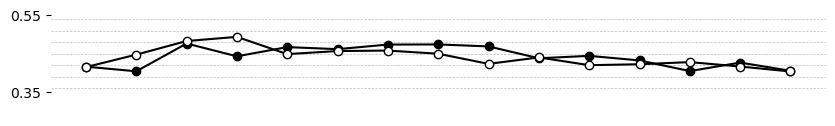

Figure saved to: C:\github\Segmentation\Figures\Figure_A\K9-Knee_ARI.png


In [ ]:
## Figure C - Reproducibility ARI ##
# ARI, Generate scatter plot, x number of clusters, y Dice_coeff

# Clear all the variables
%reset -f
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker   # ← new import
reload(figure_utils)

figure_letter = 'C'
username = 'raulh87'
grid_spacing = 0.03

stat_to_plot = 'z' # m: mean or z: for z-score
comp_names = ['healthy','Knee']
save_file = True
color_comb = 'white' # tales 'white' or 'black'

y_limits_dict = {comp: {'min_y': np.nan, 'max_y': np.nan} for comp in comp_names}
# set healthy to 0.40 and 0.70
y_limits_dict['healthy']['min_y'] = 0.35
y_limits_dict['healthy']['max_y'] = 0.55
y_limits_dict['healthy']['marker'] = 'o'
y_limits_dict['healthy']['markerfacecolor'] = 'black'   # filled
y_limits_dict['healthy']['markeredgecolor'] = 'black'   # filled

y_limits_dict['Knee']['min_y'] = 0.35
y_limits_dict['Knee']['max_y'] = 0.55
y_limits_dict['Knee']['marker'] = 'o'
y_limits_dict['Knee']['markerfacecolor'] = 'white'   # open
y_limits_dict['Knee']['markeredgecolor'] = 'black'   # open

if color_comb == 'white':
    opposite_color = 'black'
elif color_comb == 'black':
    opposite_color = 'white'
else:
    raise ValueError('color_comb must be white or black')

dataset = 'CAPS_K9'
experiment = 'CAPS'
figure_dims = (10, 1)
project_dict = figure_utils.get_project_dict('K9')[0]
figures_folder = figure_utils.get_path('Figures', project_dict, figure_letter)
res_path = r"G:\My Drive\Results\CAPS\cluster_stats\ARI.csv"
# Load the res_df
res_df = pd.read_csv(res_path)
fig, ax = plt.subplots(figsize=figure_dims)

for comp in comp_names:
    # Make a plot for each stat
    res_filtered = res_df[res_df['comp_name'] == comp]   

    # create figure
    
    # get the y values and x values
    y_values = res_filtered['ARI'].values
    x_values = res_filtered['number_of_clusters'].values
    # plot the data
    ax.plot(x_values, y_values, marker=y_limits_dict[comp]['marker'], 
            markerfacecolor=y_limits_dict[comp]['markerfacecolor'], 
            markeredgecolor=y_limits_dict[comp]['markeredgecolor'], 
            linestyle='-', label='Data', color=opposite_color)
    # ax.plot(x_values, y_values, 'o-', label='Data', color=opposite_color)
    
    # get min_y and max_y
    min_y = min(y_values)
    max_y = max(y_values)
    # define percentage to add to the y-axis
    perc = 0.1
    
    # add 10% of the y-axis
    if min_y < 0:
        min_y = min_y + min_y*perc
    else:
        min_y = min_y - min_y*perc
    if max_y < 0:
        max_y = max_y - max_y*perc
    else:
        max_y = max_y + max_y*perc
    
    
    # round min_y to the nearest 0.1
    min_y = round(min_y - 0.01, 2)
    
    # round max_y to the nearest 0.1
    max_y = round(max_y + 0.01, 2)

    # if min_y <= 0.1 make it zero
    if min_y <= 0.1:
        min_y = 0

    # overwrite if limits are not NaN
    if not np.isnan(y_limits_dict[comp]['min_y']):
        min_y = y_limits_dict[comp]['min_y']
    if not np.isnan(y_limits_dict[comp]['max_y']):
        max_y = y_limits_dict[comp]['max_y']

    # Set the y-axis limits to the min and max of y_values
    ax.set_ylim([min_y, max_y])
    # ─────────────── y-axis ticks & grid ───────────────
    # major ticks: just min and max
    ax.yaxis.set_major_locator(mticker.FixedLocator([min_y, max_y]))
    # minor ticks: every grid_spacing
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(grid_spacing))
    # draw grid only at minor ticks
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    # optionally turn off any major grid
    ax.grid(which='major', color='none')
    
    # ensure only major tick labels appear
    ax.tick_params(axis='y', which='minor', length=0)

    # Set the background color to none
    ax.set_facecolor('none')

    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_visible(False)
    # hide x-axis ticks and labels
    ax.tick_params(axis='x', colors='none')
    # color the y-axis labels
    ax.tick_params(axis='y', colors=opposite_color)
# Show the plot
plt.show()

# Determine path
figure_path = os.path.join(figures_folder, 'K9-' + comp + '_' + 'ARI' + '.png')
if save_file:
    # Save the figure with transparency
    fig.savefig(figure_path, transparent=True)
    print('Figure saved to: ' + figure_path)
else:
    print(figure_path + ' not saved')


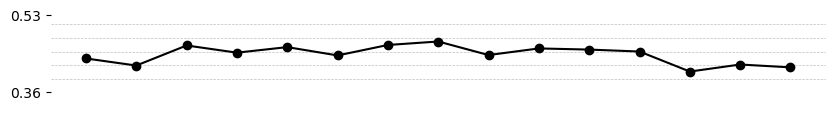

Figure saved to: C:\github\Segmentation\Figures\Figure_A\all_ARI.png


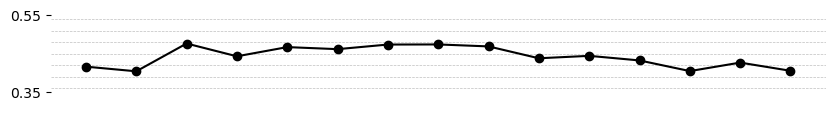

Figure saved to: C:\github\Segmentation\Figures\Figure_A\healthy_ARI.png


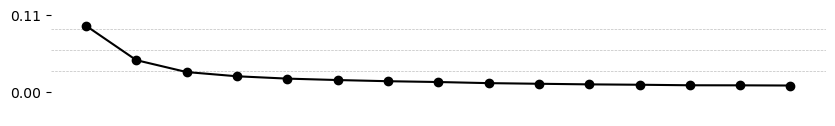

Figure saved to: C:\github\Segmentation\Figures\Figure_A\Johnson_ARI.png


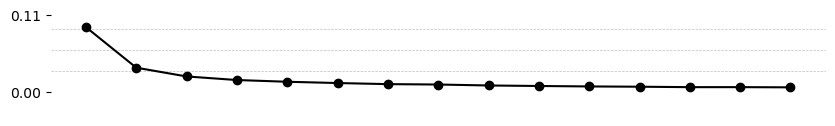

Figure saved to: C:\github\Segmentation\Figures\Figure_A\Johnson_gyri_ARI.png


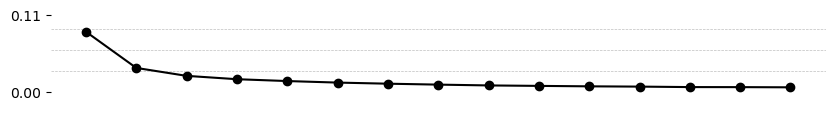

Figure saved to: C:\github\Segmentation\Figures\Figure_A\Johnson_lobe_ARI.png


In [ ]:
## Figure C - Reproducibility ARI ##
# ARI, Generate scatter plot, x number of clusters, y Dice_coeff

# Clear all the variables
%reset -f
import os
import nibabel as nib
import pandas as pd
import numpy as np
import figure_utils  # Ensure this is correctly imported or defined
from scipy.special import comb
from importlib import reload
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker   # ← new import
reload(figure_utils)

figure_letter = 'C'
grid_spacing = 0.03

stat_to_plot = 'z' # m: mean or z: for z-score
comp_names = ['healthy','Johnson', 'Johnson_gyri', 'Johnson_lobe']
save_file = True
color_comb = 'white' # tales 'white' or 'black'

y_limits_dict = {comp: {'min_y': np.nan, 'max_y': np.nan} for comp in comp_names}
# set healthy to 0.40 and 0.70
y_limits_dict['healthy']['min_y'] = 0.35
y_limits_dict['healthy']['max_y'] = 0.55

if color_comb == 'white':
    opposite_color = 'black'
elif color_comb == 'black':
    opposite_color = 'white'
else:
    raise ValueError('color_comb must be white or black')

dataset = 'CAPS_K9'
experiment = 'CAPS'
figure_dims = (10, 1)
project_dict = figure_utils.get_project_dict('K9')[0]
figures_folder = figure_utils.get_path('Figures', project_dict, figure_letter)
res_path = r"C:\github\spatially_constrained_spectral_clustering\results\ARI.csv"
# Load the res_df
res_df = pd.read_csv(res_path)


for comp in comp_names:
    # Make a plot for each stat
    res_filtered = res_df[res_df['comp_name'] == comp]   

    # create figure
    fig, ax = plt.subplots(figsize=figure_dims)
    # get the y values and x values
    y_values = res_filtered['ARI'].values
    x_values = res_filtered['number_of_clusters'].values
    # plot the data
    ax.plot(x_values, y_values, 'o-', label='Data', color=opposite_color)
    
    # get min_y and max_y
    min_y = min(y_values)
    max_y = max(y_values)
    # define percentage to add to the y-axis
    perc = 0.1
    
    # add 10% of the y-axis
    if min_y < 0:
        min_y = min_y + min_y*perc
    else:
        min_y = min_y - min_y*perc
    if max_y < 0:
        max_y = max_y - max_y*perc
    else:
        max_y = max_y + max_y*perc
    
    
    # round min_y to the nearest 0.1
    min_y = round(min_y - 0.01, 2)
    
    # round max_y to the nearest 0.1
    max_y = round(max_y + 0.01, 2)

    # if min_y <= 0.1 make it zero
    if min_y <= 0.1:
        min_y = 0

    # overwrite if limits are not NaN
    if not np.isnan(y_limits_dict[comp]['min_y']):
        min_y = y_limits_dict[comp]['min_y']
    if not np.isnan(y_limits_dict[comp]['max_y']):
        max_y = y_limits_dict[comp]['max_y']

    # Set the y-axis limits to the min and max of y_values
    ax.set_ylim([min_y, max_y])
    # ─────────────── y-axis ticks & grid ───────────────
    # major ticks: just min and max
    ax.yaxis.set_major_locator(mticker.FixedLocator([min_y, max_y]))
    # minor ticks: every grid_spacing
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(grid_spacing))
    # draw grid only at minor ticks
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    # optionally turn off any major grid
    ax.grid(which='major', color='none')
    
    # ensure only major tick labels appear
    ax.tick_params(axis='y', which='minor', length=0)

    # Set the background color to none
    ax.set_facecolor('none')

    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_visible(False)
    # hide x-axis ticks and labels
    ax.tick_params(axis='x', colors='none')
    # color the y-axis labels
    ax.tick_params(axis='y', colors=opposite_color)
    # Show the plot
    plt.show()

    # Determine path
    figure_path = os.path.join(figures_folder, comp + '_' + 'ARI' + '.png')
    if save_file:
        # Save the figure with transparency
        fig.savefig(figure_path, transparent=True)
        print('Figure saved to: ' + figure_path)
    else:
        print(figure_path + ' not saved')
